<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/W1D2_new/tutorials/W1D2_LinearNN/W1D2_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DL Neuromatch Academy: Week 1, Day 2, Tutorial 3
# Deep Linear Neural Networks

__Content creators:__ Andrew Saxe, Saeed Salehi, Vladimir Haltakov



__Content reviewers:__ Polina Turishcheva, Atnafu Lambebo, Yu-Fang Yang

__Content editors:__ Anoop Kulkarni

__Production editors:__ Khalid Almubarak, , Spiros Chavlis

---
#Tutorial Objectives

* Deep linear neural networks
* Learning dynamics and singular value decomposition
* Representational Similarity Analysis
* Illusory correlations & ethics. 



In [1]:
#@markdown Tutorial slides
# you should link the slides for all tutorial videos here (we will store pdfs on osf)

from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/1kfWWYhSIkczYfjebhMaqQILTCu7g94Q-o_ZcWb1QAKs/embed?start=false&loop=false&delayms=3000" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

---
# Setup


In [2]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import random
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm, trange
import time
from math import sqrt

! pip install treelib --quiet
from treelib import Node, Tree

In [3]:
# @title Figure settings
# import ipywidgets as widgets
# from ipywidgets import interact, fixed, HBox, Layout, VBox, interactive, Label
# from ipywidgets import interact, IntSlider, FloatSlider, interact_manual
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from ipywidgets import interact, IntSlider, FloatSlider, interact_manual, fixed
from ipywidgets import FloatLogSlider, HBox, Layout, VBox, interactive, Label
from ipywidgets import interactive_output

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
#@title Plotting functions

def plot_x_y_hier_data(im1, im2, subplot_ratio=[1, 2]):
  fig = plt.figure(figsize=(12, 5)) 
  gs = gridspec.GridSpec(1, 2, width_ratios=subplot_ratio) 
  ax0 = plt.subplot(gs[0])
  ax1 = plt.subplot(gs[1])
  ax0.imshow(im1, cmap="cool")
  ax1.imshow(im2, cmap="cool")
  # plt.suptitle("The whole dataset as imshow plot", y=1.02)
  ax0.set_title("Labels of all samples")
  ax1.set_title("Features of all samples")
  ax0.set_axis_off()
  ax1.set_axis_off()
  plt.tight_layout()
  plt.show()


def plot_x_y_hier_one(im1, im2, subplot_ratio=[1, 2]):
  fig = plt.figure(figsize=(12, 1)) 
  gs = gridspec.GridSpec(1, 2, width_ratios=subplot_ratio) 
  ax0 = plt.subplot(gs[0])
  ax1 = plt.subplot(gs[1])
  ax0.imshow(im1, cmap="cool")
  ax1.imshow(im2, cmap="cool")
  ax0.set_title("Labels of a single sample")
  ax1.set_title("Features of a single sample")
  ax0.set_axis_off()
  ax1.set_axis_off()
  plt.tight_layout()
  plt.show()

def plot_tree_data(im1, im2, label_list):
  im1_dim1, im1_dim2 = im1.shape

  fig = plt.figure(figsize=(12, 5)) 
  gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
  ax0 = plt.subplot(gs[0])
  ax1 = plt.subplot(gs[1])
  ax0.imshow(im1, cmap="cool")
  ax1.imshow(im2[:, -im1_dim1*2:], cmap="cool", vmin=0.0, vmax=1.0)
  ax0.set_title("all the Labels")
  ax1.set_title("last {} Features".format(-im1_dim1*2))
  ax0.set_yticks(ticks=np.arange(im1_dim1))
  ax0.set_yticklabels(labels=label_list)
  ax0.set_xticks(ticks=np.arange(im1_dim1))
  ax0.set_xticklabels(labels=item_names, rotation='vertical')
  ax1.set_axis_off()
  plt.tight_layout()
  plt.show()


def plot_loss(loss_array, title="Training loss (Mean Squared Error)", c="r"):
  plt.figure(figsize=(9, 5))
  plt.plot(loss_array, color=c)
  plt.xlabel("Epoch")
  plt.ylabel("MSE")
  plt.title(title)
  plt.show()


def plot_loss_sv(loss_array, sv_array):
  n_sing_values = sv_array.shape[1]
  sv_array = sv_array / np.max(sv_array)
  cmap = plt.cm.get_cmap("Set1", n_sing_values)

  _, (plot1, plot2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
  plot1.set_title("Training loss (Mean Squared Error)")
  plot1.plot(loss_array, color='r')

  plot2.set_title("Evolution of singular values (modes)")
  for i in range(n_sing_values):
    plot2.plot(sv_array[:, i], c=cmap(i))
  plot2.set_xlabel("Epoch")
  plt.show()


def plot_loss_sv_twin(loss_array, sv_array):
  n_sing_values = sv_array.shape[1]
  sv_array = sv_array / np.max(sv_array)
  cmap = plt.cm.get_cmap("winter", n_sing_values)

  fig = plt.figure(figsize=(11, 6))
  ax1 = plt.gca()
  ax1.set_title("Learning Dynamics")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Mean Squared Error", c='r')
  ax1.tick_params(axis='y', labelcolor='r')
  ax1.plot(loss_array, color='r')

  ax2 = ax1.twinx()
  ax2.set_ylabel("Singular values (modes)", c='b')
  ax2.tick_params(axis='y', labelcolor='b')
  for i in range(n_sing_values):
    ax2.plot(sv_array[:, i], c=cmap(i))

  fig.tight_layout()
  plt.show()


def plot_ills_sv_twin(ill_array, sv_array):
  n_sing_values = sv_array.shape[1]
  sv_array = sv_array / np.max(sv_array)
  cmap = plt.cm.get_cmap("winter", n_sing_values)

  fig = plt.figure(figsize=(11, 6))
  ax1 = plt.gca()
  ax1.set_title("Network evolution in learning the Illusory Correlations")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Illusory Correlations", c='r')
  ax1.tick_params(axis='y', labelcolor='r')
  ax1.plot(ill_array, color='r', linewidth=3)
  ax1.set_ylim(-0.05, 1.0)

  ax2 = ax1.twinx()
  ax2.set_ylabel("Singular values (modes)", c='b')
  ax2.tick_params(axis='y', labelcolor='b')
  for i in range(n_sing_values):
    ax2.plot(sv_array[:, i], c=cmap(i))

  fig.tight_layout()
  plt.show()


def plot_loss_sv_rsm(loss_array, sv_array, rsm_array, i_ep):
  rsm_array = rsm_array / np.max(rsm_array, axis=0)
  sv_array = sv_array / np.max(sv_array)

  n_sing_values = sv_array.shape[1]
  cmap = plt.cm.get_cmap("winter", n_sing_values)

  fig = plt.figure(figsize=(15, 5)) 
  gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

  ax0 = plt.subplot(gs[1])
  ax0.yaxis.tick_right()
  ax0.imshow(rsm_array[i_ep], cmap="Purples", vmin=0.0, vmax=1.1)
  ax0.set_title("RSM at epoch {}".format(i_ep), fontsize=16)
  # ax0.set_axis_off()
  ax0.set_yticks(ticks=np.arange(n_sing_values))
  ax0.set_yticklabels(labels=item_names)
  # ax0.set_xticks([])
  ax0.set_xticks(ticks=np.arange(n_sing_values))
  ax0.set_xticklabels(labels=item_names, rotation='vertical')

  ax1 = plt.subplot(gs[0])
  ax1.set_title("Learning Dynamics", fontsize=16)
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Mean Squared Error", c='r')
  ax1.tick_params(axis='y', labelcolor='r')
  ax1.plot(loss_array, color='r')
  ax1.axvspan(i_ep-2, i_ep+2, alpha=0.2, color='m')

  ax2 = ax1.twinx()
  ax2.set_ylabel("Singular values", c='b')
  ax2.tick_params(axis='y', labelcolor='b')
  for i in range(n_sing_values):
    ax2.plot(sv_array[:, i], c=cmap(i))
  
  plt.show()

class SimpleTree:
  def __init__(self, plot=False):
    tree = Tree()
    tree.create_node("Living things", 0)
    tree.create_node("Animal", 1, parent=0)
    tree.create_node("Plant", 2, parent=0)
    tree.create_node("Fish", 3, parent=1)
    tree.create_node("Bird", 4, parent=1)
    tree.create_node("Flower", 5, parent=2)
    tree.create_node("Tree", 6, parent=2)
    tree.create_node("Goldfish", 7, parent=3)
    tree.create_node("Tuna", 8, parent=3)
    tree.create_node("Robin", 9, parent=4)
    tree.create_node("Canary", 10, parent=4)
    tree.create_node("Rose", 11, parent=5)
    tree.create_node("Daisy", 12, parent=5)
    tree.create_node("Pine", 13, parent=6)
    tree.create_node("Oak", 14, parent=6)
    self.tree = tree
    if plot: self.plot()

  def plot(self):
    self.tree.show(line_type="ascii-em")
  
  def rename(self, old, new, plot=False):
    for nodes in self.tree.all_nodes():
      if nodes.tag == old:
        nodes.tag = new
        break
    if plot: self.plot()


In [5]:
#@title Helper functions

seed = 2015  # LeCun, Bengio, & Hinton (2015)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class VariableDepthWidth(nn.Module):
  def __init__(self, in_dim, out_dim, hid_dims=[], gamma=1e-12):
    """Variable depth linear network
 
    Args:
      in_dim (int): input dimension
      out_dim (int): ouput dimension
      hid_dims (list): a list, containing the number of neurons in each hidden layer
        default is empty list (`[]`) for linear regression.
        example: For 2 hidden layers, first with 5 and second with 7 neurons,
                 we use: `hid_dims = [5, 7]`
    """
    super().__init__()
    assert isinstance(in_dim, int)
    assert isinstance(out_dim, int)
    assert isinstance(hid_dims, list)
    n_hidden_layers = len(hid_dims)  # number of hidden layers
    layers = OrderedDict()

    if n_hidden_layers == 0:  # linear regression
      layers["map"] = nn.Linear(in_dim, out_dim, bias=False)

    else:  # shallow and deep linear neural net
      layers["in->"] = nn.Linear(in_dim, hid_dims[0], bias=False)

      for i in range(n_hidden_layers-1):  # creating hidden layers
        layers["hid {}".format(i+1)] = nn.Linear(hid_dims[i],
                                                    hid_dims[i+1],
                                                    bias=False)

      layers["->out"] = nn.Linear(hid_dims[-1], out_dim, bias=False)

    for k in layers:  # re-initialization of the weights
      sigma = gamma / sqrt(layers[k].weight.shape[0] + layers[k].weight.shape[1])
      nn.init.normal_(layers[k].weight, std=sigma)

    self.layers = nn.Sequential(layers)
      
  def forward(self, input_tensor):
    """Forward pass
    """
    return self.layers(input_tensor)


def build_tree(n_levels, n_branches, probability, to_np_array=True):
  """Builds a tree
  """
  assert 0.0 <= probability <= 1.0

  tree = {}

  tree["level"] = [0]
  for i in range(1, n_levels+1):
    tree["level"].extend([i]*(n_branches**i))

  tree["pflip"] = [probability]*len(tree["level"])

  tree["parent"] = [None]
  k = len(tree["level"])-1
  for j in range(k//n_branches):
    tree["parent"].extend([j]*n_branches)

  if to_np_array:
    tree["level"] = np.array(tree["level"])
    tree["pflip"] = np.array(tree["pflip"])
    tree["parent"] = np.array(tree["parent"])

  return tree


def sample_from_tree(tree, n):
  """ Generates n samples from a tree
  """
  items = [i for i, v in enumerate(tree["level"]) if v == max(tree["level"])]
  n_items = len(items)
  x = np.zeros(shape=(n, n_items))
  rand_temp = np.random.rand(n, len(tree["pflip"]))
  flip_temp = np.repeat(tree["pflip"].reshape(1, -1), n, 0)
  samp = (rand_temp > flip_temp) * 2 - 1

  for i in range(n_items):
    j = items[i]
    prop = samp[:, j]
    while tree["parent"][j] is not None:
      j = tree["parent"][j]
      prop = prop * samp[:, j]
    x[:, i] = prop.T
  return x

def generate_hsd():
  # building the tree
  n_branches = 2  # 2 branches at each node
  probability = .15  # flipping probability
  n_levels = 3  # number of levels (depth of tree)
  tree = build_tree(n_levels, n_branches, probability, to_np_array=True)
  tree["pflip"][0] = 0.5
  n_samples = 10000 # Sample this many features

  tree_labels = np.eye(n_branches**n_levels)
  tree_features = sample_from_tree(tree, n_samples).T
  return tree_labels, tree_features


def linear_regression(X, Y):
  """Analytical Linear regression

  """
  assert isinstance(X, np.ndarray)
  assert isinstance(Y, np.ndarray)
  M, Dx = X.shape
  N, Dy = Y.shape
  assert Dy == Dy
  W = Y @ X.T @ np.linalg.inv(X @ X.T)
  return W

# #@markdown Run this cell to define the train function!

def train_svd_rsa_track(model, in_features, out_features, n_epochs, lr, ill_i=0):
  """Training function
  
  Args:
    model (torch nn.Module): the neural network
    in_features (torch.Tensor): features (input) with shape `torch.Size([batch_size, input_dim])`
    out_features (torch.Tensor): targets (labels) with shape `torch.Size([batch_size, output_dim])`
    n_epochs (int): number of training epochs
    lr (float): learning rate
    ill_i (int): index of illusory feature

  Returns:
    np.ndarray: record (evolution) of losses
    np.ndarray: record (evolution) of singular values
    np.ndarray: record (evolution) of representational similarity matrices
    np.ndarray: record of network prediction for the last feature
  """
  
  assert in_features.shape[0] == out_features.shape[0]
  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  xd = in_features.shape[1]
  loss_record = []  # losses
  sv_record = []  # singular values
  rsm_record = []  # represent sim mats
  pred_record = []  # network prediction for the last feature

  for i in range(n_epochs):
    y_pred = model(in_features)  # forward pass
    loss = criterion(y_pred, out_features)  # calculating the loss
    optimizer.zero_grad()  # reset all the graph gradients to zero
    loss.backward()  # back propagation of the error
    optimizer.step()  # gradient step
    
    # calculating the W_tot by multiplying all layers' weights
    W_tot = model.layers[-1].weight.detach()  # starting from the last layer
    for i in range(2, len(model.layers)+1):
      W_tot = W_tot @ model.layers[-i].weight.detach()
    U, Σ, V = torch.svd(W_tot)  # performing the SVD!

    # calculating representational similarity matrix
    H1 = model.layers[0].weight.detach() @ in_features
    RSM = H1.T @ H1

    # network prediction of ill_i in_feature for the last feature
    ill_pred = y_pred[ill_i, -1].detach().numpy()

    loss_record.append(loss.item())
    sv_record.append(Σ.numpy())
    rsm_record.append(RSM.numpy())
    pred_record.append(ill_pred)

  return np.array(loss_record), np.array(sv_record), np.array(rsm_record), np.array(pred_record)


def add_feature(existing_features, new_feature):
  assert isinstance(existing_features, np.ndarray)
  assert isinstance(new_feature, list)
  new_feature = np.array([new_feature]).T
  # return np.hstack((tree_features, new_feature*2-1))
  return np.hstack((tree_features, new_feature))

---
# Section 0: Prelude

## Exercise 0: Variable depth and width LNN
Throughout this tutorial, we will need several neural nets with different depth and width. So first, let's create a model with variable depth and width.

This can be easily done by using [`OrderedDict()`](https://docs.python.org/3/library/collections.html#collections.OrderedDict) and `nn.Sequential` function. The model is defined by its input and output dimensions, and a list containing the width of each hidden layer. If the list is left empty, the neural network will perform a linear regression (coming up next). We also exclude the `bias` from all the layers.

We also take over the initialization. In PyTorch, we can use [`nn.init`](https://pytorch.org/docs/stable/nn.init.html) to initialize tensors from a given distribution. Here, we sample the weights from the following distribution:

$$\mathcal{N}\left(\mu=0, ~~\sigma=\gamma \sqrt{\dfrac{1}{n_{in} + n_{out}}} \right)$$

where $\gamma$ is given as an argument. the Underscore ("_") in `nn.init.random_` and other functions, denote "in-place" operation. Note that `nn.Linear` layers are initialized at definition, so we re-initialize them.

In [6]:
class VariableDepthWidthExercise(nn.Module):
  def __init__(self, in_dim, out_dim, hid_dims=[], gamma=1e-12):
    """Variable depth linear network
 
    Args:
      in_dim (int): input dimension
      out_dim (int): ouput dimension
      hid_dims (list): a list, containing the number of neurons in each hidden layer
        default is empty list (`[]`) for linear regression.
        example: For 2 hidden layers, first with 5 and second with 7 neurons,
                 we use: `hid_dims = [5, 7]`
    """
    super().__init__()
    assert isinstance(in_dim, int)
    assert isinstance(out_dim, int)
    assert isinstance(hid_dims, list)
    n_hidden_layers = len(hid_dims)  # number of hidden layers
    layers = OrderedDict()

    if n_hidden_layers == 0:  # linear regression
      layers["map"] = nn.Linear(in_dim, out_dim, bias=False)

    else:  # shallow and deep linear neural net
      layers["in->"] = nn.Linear(in_dim, hid_dims[0], bias=False)

      for i in range(n_hidden_layers-1):  # creating hidden layers
        #################################################
        ## Complete the hidden loop of DeepLNNExercise class
        # Complete the function and remove or comment the line below
        raise NotImplementedError("Network model `DeepLNNExercise`")
        #################################################

    for k in layers:  # re-initialization of the weights
      sigma = gamma / sqrt(layers[k].weight.shape[0] + layers[k].weight.shape[1])
      nn.init.normal_(layers[k].weight, std=sigma)

    self.layers = nn.Sequential(layers)
      
  def forward(self, input_tensor):
    """Forward pass
    """
    return self.layers(input_tensor)


# # Uncomment and run
# print("Deep LNN:\n",
#       VariableDepthWidthExercise(64, 100, [32, 16, 16, 32]))

# print("\nLinear Regression model:\n",
#       VariableDepthWidthExercise(64, 100,[]))

In [7]:
# to_remove solution
class VariableDepthWidthExercise(nn.Module):
  def __init__(self, in_dim, out_dim, hid_dims=[], gamma=1e-12):
    """Variable depth linear network
 
    Args:
      in_dim (int): input dimension
      out_dim (int): ouput dimension
      hid_dims (list): a list, containing the number of neurons in each hidden layer
        default is empty list (`[]`) for linear regression.
        example: For 2 hidden layers, first with 5 and second with 7 neurons,
                 we use: `hid_dims = [5, 7]`
    """
    super().__init__()
    assert isinstance(in_dim, int)
    assert isinstance(out_dim, int)
    assert isinstance(hid_dims, list)
    n_hidden_layers = len(hid_dims)  # number of hidden layers
    layers = OrderedDict()

    if n_hidden_layers == 0:  # linear regression
      layers["map"] = nn.Linear(in_dim, out_dim, bias=False)

    else:  # shallow and deep linear neural net
      layers["in->"] = nn.Linear(in_dim, hid_dims[0], bias=False)

      for i in range(n_hidden_layers-1):  # creating hidden layers
        layers["hid {}".format(i+1)] = nn.Linear(hid_dims[i],
                                                    hid_dims[i+1],
                                                    bias=False)

      layers["->out"] = nn.Linear(hid_dims[-1], out_dim, bias=False)

    for k in layers:  # re-initialization of the weights
      sigma = gamma / sqrt(layers[k].weight.shape[0] + layers[k].weight.shape[1])
      nn.init.normal_(layers[k].weight, std=sigma)

    self.layers = nn.Sequential(layers)
      
  def forward(self, input_tensor):
    """Forward pass
    """
    return self.layers(input_tensor)


# # Uncomment and run
print("Deep LNN:\n",
      VariableDepthWidthExercise(64, 100, [32, 16, 16, 32]))

print("\nLinear Regression model:\n",
      VariableDepthWidthExercise(64, 100,[]))

Deep LNN:
 VariableDepthWidthExercise(
  (layers): Sequential(
    (in->): Linear(in_features=64, out_features=32, bias=False)
    (hid 1): Linear(in_features=32, out_features=16, bias=False)
    (hid 2): Linear(in_features=16, out_features=16, bias=False)
    (hid 3): Linear(in_features=16, out_features=32, bias=False)
    (->out): Linear(in_features=32, out_features=100, bias=False)
  )
)

Linear Regression model:
 VariableDepthWidthExercise(
  (layers): Sequential(
    (map): Linear(in_features=64, out_features=100, bias=False)
  )
)


We have prepare the training function (very similar to that of tutorial 1) for you already. Just look check if everything is okay.

In [8]:
def train(model, in_features, out_features, n_epochs, lr,
          criterion=None, optimizer=None, show_progress_bar=False):
  """Training function
  
  Args:
    model (torch nn.Module): the neural network
    in_features (torch.Tensor): features (input) with shape `torch.Size([batch_size, input_dim])`
    out_features (torch.Tensor): targets (labels) with shape `torch.Size([batch_size, output_dim])`
    n_epochs (int): number of training epochs
    criterion (function): loss function (default 'nn.MSELoss()')
    optimizer(function): optimizer (default 'optim.SGD')
    lr(float): learning rate

  Returns:
    list: record (evolution) of losses
  """
  
  assert in_features.shape[0] == out_features.shape[0]
  loss_record = []  # for recoding losses
  
  if optimizer is None:
      optimizer = optim.SGD(model.parameters(), lr=lr)
  if criterion is None:
      criterion = nn.MSELoss()

  model.train()  # we first put the model in training mode

  for i in range(n_epochs):
    y_pred = model(in_features)  # forward pass
    loss = criterion(y_pred, out_features)  # calculating the loss
    optimizer.zero_grad()  # reset all the graph gradients to zero
    loss.backward()  # back propagation of the error
    optimizer.step()  # gradient step

    loss_record.append(loss.item())

  model.eval()  # putting the model to evaluation mode

  return loss_record


---
# Section 00: Analytical Linear Regression

Linear regression is a relatively simple optimization problem. Unlike most other models that we will see in this course, linear regression for mean squared loss can be solved analytically.

For $D$ samples (batch size), $\mathbf{X} \in \mathbb{R}^{M \times D}$, and $\mathbf{Y} \in \mathbb{R}^{N \times D}$, the goal of linear regression is to find $\mathbf{W} \in \mathbb{R}^{N \times M}$ such that:

$$\mathbf{Y} = \mathbf{W} ~ \mathbf{X} $$

Given the Squared Error loss function, we have:

\begin{equation}
Loss(\mathbf{W}) = ||\mathbf{Y} - \mathbf{W} ~ \mathbf{X}||^2
\end{equation}

So, using matrix notation, the optimization problem is given by:

\begin{align}
\mathbf{W^{*}} &= \underset{\mathbf{W}}{\mathrm{argmin}} \left( Loss (\mathbf{W})  \right) \\
 &= \underset{\mathbf{W}}{\mathrm{argmin}} \left( ||\mathbf{Y} - \mathbf{W} ~ \mathbf{X}||^2  \right) \\
&= \underset{\mathbf{W}}{\mathrm{argmin}} \left( \left( \mathbf{Y} - \mathbf{W} ~ \mathbf{X}\right)^{\top} \left( \mathbf{Y} - \mathbf{W} ~ \mathbf{X}\right) \right)
\end{align}

To solve the minimization problem, we can simply set the derivative of the loss with respect to $\mathbf{W}$ to zero.

\begin{equation}
\dfrac{\partial Loss}{\partial \mathbf{W}} = 0
\end{equation}

Assuming that $\mathbf{X}\mathbf{X}^{\top}$ is full-rank, and thus it is invertible we can write:

\begin{equation}
\mathbf{W}^{\mathbf{*}} = \mathbf{Y} \mathbf{X}^{\top} \left( \mathbf{X}  \mathbf{X}^{\top} \right) ^{-1}
\end{equation}



## Exercise 00: Analytical solution to LR

Complete the function `linear_regression` for finding the analytical solution to linear regression.


In [9]:
def linear_regression_exercise(X, Y):
  """Analytical Linear regression

  Args:
    X (np.ndarray): design matrix
    Y (np.ndarray): target ouputs
  
  return:
    np.ndarray: estimated weights (mapping)
  """
  assert isinstance(X, np.ndarray)
  assert isinstance(Y, np.ndarray)
  M, Dx = X.shape
  N, Dy = Y.shape
  assert Dy == Dy

  #################################################
  ## Complete the linear_regression_exercise function
  # Complete the function and remove or comment the line below
  raise NotImplementedError("Linear Regression `linear_regression_exercise`")
  #################################################
  W = ...

  return W


W_true = np.random.randint(low=0, high=10, size=(3, 3)).astype(float)

X_train = np.random.rand(3, 37)  # 37 samples
noise = np.random.normal(scale=0.01, size=(3, 37))
Y_train = W_true @ X_train + noise

# # Uncomment and run
# W_estimate = linear_regression_exercise(X_train, Y_train)

# print("True weights:\n", W_true)
# print("\nEstimated weights:\n", np.round(W_estimate, 1))

In [10]:
# to_remove solution
def linear_regression_exercise(X, Y):
  """Analytical Linear regression

  Args:
    X (np.ndarray): design matrix
    Y (np.ndarray): target ouputs
  
  return:
    np.ndarray: estimated weights (mapping)
  """
  assert isinstance(X, np.ndarray)
  assert isinstance(Y, np.ndarray)
  M, Dx = X.shape
  N, Dy = Y.shape
  assert Dy == Dy

  W = Y @ X.T @ np.linalg.inv(X @ X.T)

  return W


W_true = np.random.randint(low=0, high=10, size=(3, 3)).astype(float)

X_train = np.random.rand(3, 37)  # 37 samples
noise = np.random.normal(scale=0.01, size=(3, 37))
Y_train = W_true @ X_train + noise

# # Uncomment and run
W_estimate = linear_regression_exercise(X_train, Y_train)

print("True weights:\n", W_true)
print("\nEstimated weights:\n", np.round(W_estimate, 1))

True weights:
 [[8. 1. 5.]
 [3. 8. 6.]
 [9. 5. 9.]]

Estimated weights:
 [[8. 1. 5.]
 [3. 8. 6.]
 [9. 5. 9.]]


---
# Section 1: Deep Linear Neural Nets

Video available at https://youtu.be/MRPy6uZRxms


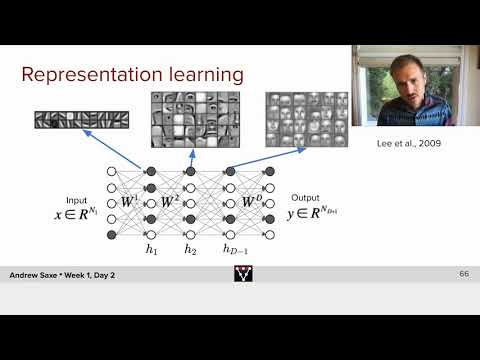

In [11]:
#@title Video 1: Representation Learning (Intro)
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="MRPy6uZRxms", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


So far depth just seems to slow down the learning. And we know that a single nonlinear hidden layer (given enough number of neurons) has the potential to approximate any function. So it's seems fair to ask: **What is depth good for**? One reason can be that, shallow nonlinear neural networks hardly meet their true potential in practice.

In the contrast, deep neural nets are often surprisingly powerful in learning complex functions without sacrificing the generalization. A core intuition behind deep learning is that deep nets derive their power through learning internal representations. How does this work? To address representation learning, we have to go beyond the 1D chain, to a deep Linear Neual Network (LNN).

For this and the next couple of exercises, we use syntactically generated hierarchically structured data through a *branching diffusion process* (see [this reference](https://www.pnas.org/content/pnas/suppl/2019/05/16/1820226116.DCSupplemental/pnas.1820226116.sapp.pdf) for more details).

<center><img src="https://raw.githubusercontent.com/ssnio/statics/main/neuromatch/hierarchy.png" alt="Simple nn graph" width="400"/></center>

<center> hierarchically structured data </center>



## Exercise 1: Training a deep LNN

This is a rather simple exercise. We will generate some hierarchically structured data, instantiate a LNN from `VariableDepthWidth` class and train it on the data.

**Important note**:

* Datasets are often generated as `numpy.ndarray`, and pass to PyTorch, which needs `torch.Tensor` for training. You can use `torch.tensor(toy_data).float()` for the "conversion" of float datatype.

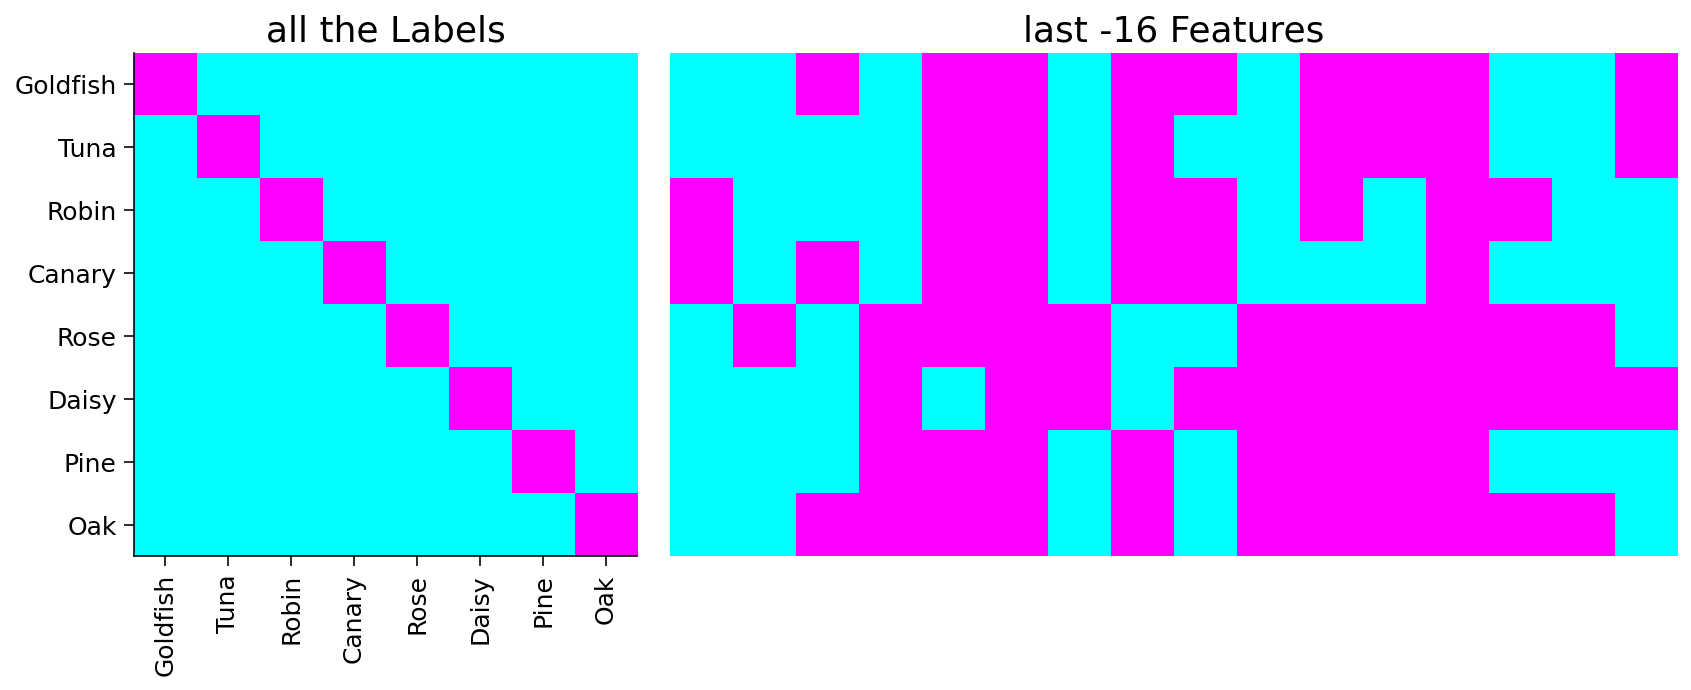


---------------------------------------------------------------
Input Dimension: 8
Output Dimension: 10000
Number of samples: 8


In [12]:
#@markdown #### Run to generate and visualize training samples from tree

tree_labels, tree_features = generate_hsd()
item_names = ['Goldfish', 'Tuna', 'Robin', 'Canary', 'Rose', 'Daisy', 'Pine', 'Oak']
plot_tree_data(tree_labels, tree_features, item_names)

# dimensions
print()
print("---------------------------------------------------------------")
print("Input Dimension: {}".format(tree_labels.shape[1]))
print("Output Dimension: {}".format(tree_features.shape[1]))
print("Number of samples: {}".format(tree_features.shape[0]))


In [13]:
def exercise_1(η=100.0, epochs=250 , γ=1e-12):
  """Training a LNN
  
  Args:
  η (float): learning rate (default 100.0)
  epochs (int): number of epochs (default 250)
  γ (float): initialization scale (default 1e-12)

  """
  n_hidden = [30]

  dim_input = tree_labels.shape[1]
  dim_output = tree_features.shape[1]

  deep_model = VariableDepthWidth(in_dim=dim_input,
                                     out_dim=dim_output,
                                     hid_dims=n_hidden,
                                     gamma=γ)

  # convert (cast) data from np.ndarray to torch.Tensor
  input_tensor = torch.tensor(tree_labels).float()
  #################################################
  ## convert output_data from np.ndarray to torch.Tensor
  # Complete the function and remove or comment the line below
  raise NotImplementedError("Cast output_data as torch.Tensor")
  #################################################
  output_tensor = ...

  training_losses = train(deep_model,
                          input_tensor,
                          output_tensor,
                          n_epochs=epochs,
                          lr=η)

  plot_loss(training_losses)


# # Uncomment and run
# exercise_1()

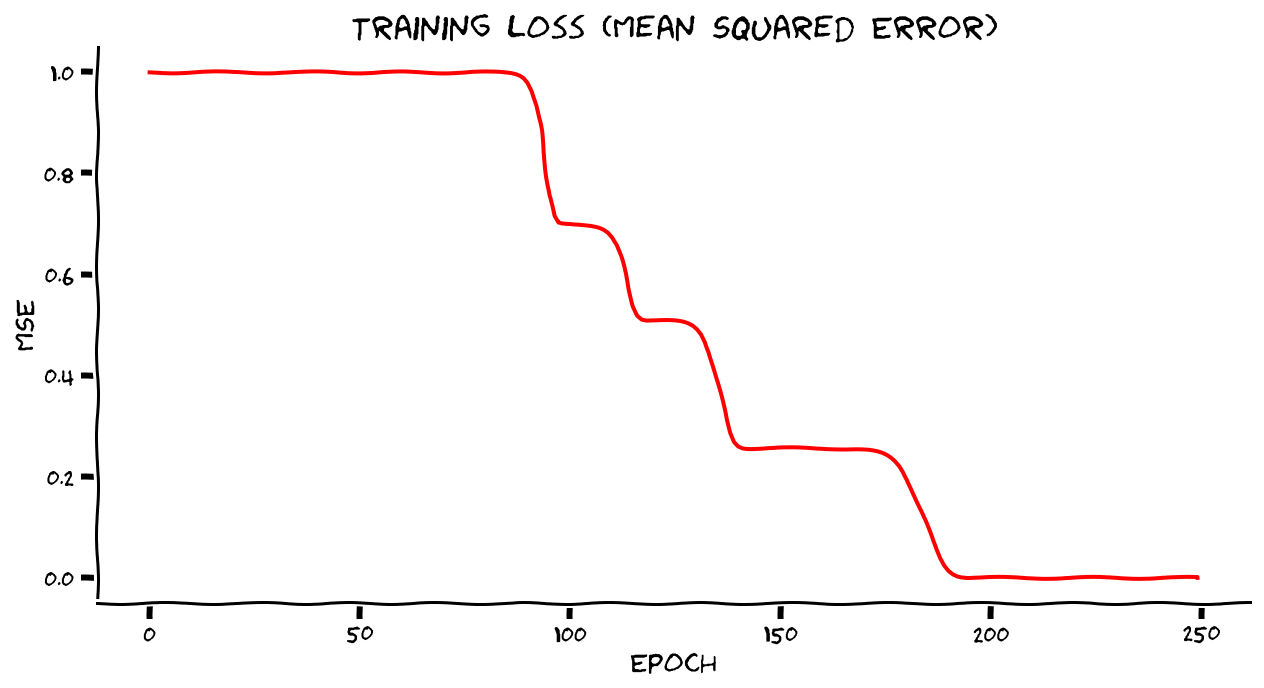

In [14]:
# to_remove solution
def exercise_1(η=100.0, epochs=250 , γ=1e-12):
  """Training a LNN
  
  Args:
  η (float): learning rate (default 100.0)
  epochs (int): number of epochs (default 250)
  γ (float): initialization scale (default 1e-12)

  """
  n_hidden = [30]

  dim_input = tree_labels.shape[1]
  dim_output = tree_features.shape[1]

  deep_model = VariableDepthWidth(in_dim=dim_input,
                                     out_dim=dim_output,
                                     hid_dims=n_hidden,
                                     gamma=γ)

  # convert (cast) data from np.ndarray to torch.Tensor
  input_tensor = torch.tensor(tree_labels).float()
  output_tensor = torch.tensor(tree_features).float()

  training_losses = train(deep_model,
                          input_tensor,
                          output_tensor,
                          n_epochs=epochs,
                          lr=η)

  plot_loss(training_losses)


# # Uncomment and run
with plt.xkcd():
  exercise_1()

**Question**: Why haven't we seen these "bumps" in training before? And should we look for them in the future? You can slide the widgets below and find your answer. Here, $\gamma$ is the initialization scale.

In [15]:
#@markdown Make sure you execute this cell to enable the widget!
_ = interact(exercise_1,
             η = FloatSlider(min=1.0, max=200.0, step=2.0, value=100.0, 
                             continuous_update=False, readout_format='.1f', description='η'),
             epochs = fixed(250),
             γ = FloatLogSlider(min=-15, max=1, step=1, value=1e-12, base=10,
                             continuous_update=False, description='γ'),
             )

interactive(children=(FloatSlider(value=100.0, continuous_update=False, description='η', max=200.0, min=1.0, r…

---
# Section 2: Singular Value Decomposition (SVD)

Video available at https://youtu.be/eTXNKMleEj8


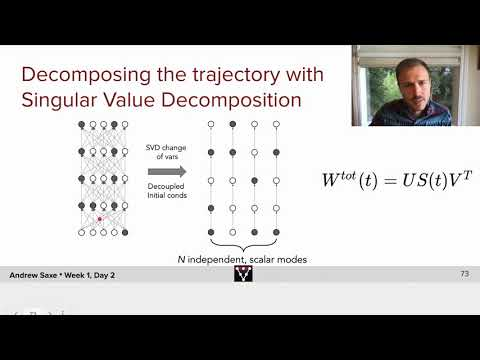

In [16]:
#@title Video 2: Singular Value Decomposition (SVD)
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="eTXNKMleEj8", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


In this section, we would go deeper in understanding of the learning dynamics we just saw. First, we should know that a linear neural network is perfoming sequential matrix maltiplications, which can simplified to:

\begin{align}
\mathbf{y} &= \mathbf{W}_{L}~\mathbf{W}_{L-1}~\dots~\mathbf{W}_{1} ~ \mathbf{x} \\
 &= (\prod_{i=1}^{L}{\mathbf{W}_{i}}) ~ \mathbf{x} \\
 &= \mathbf{W}_{tot} ~ \mathbf{x}
\end{align}

where $L$ denotes the number of layers in our network.

Why did we just called the learning progress, "learning dynamics"? Learning through gradient descent seems very aike to evolution of a dynamic system. They both are described by set of differntial equations (gradients). Dynamical systems often have a "time-constant" which describes the rate of change, similar to the learning rate, only instead of time, gradient descent evolves through epochs.

[Saxe et al. (2013)](https://arxiv.org/abs/1312.6120) showed that to analyse and to understanding the nonlinear learning dynamics of a deep LNN, we can use [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) to decompose the $\mathbf{W}_{tot}$ into orthogonal vectors, where orthogonality of the vecors would ensure their "individuality". This means we can break the a deep wide LNN to multiple deep narrow LNN, so their activity is untangled from each other.

<br/>

__A Quick intro to SVD__

Any real-valued matix $A$ (yes, ANY) can be decomposed (factorized) to 3 matrices:

\begin{equation}
\mathbf{A} = \mathbf{U} \mathbf{Σ} \mathbf{V}^{\top}
\end{equation}

where $U$ is an orthogonal matrix, $\Sigma$ is a diagonal matrix, and $V$ is again an orthogonal matrix. The diagonal elements of $\Sigma$ are called **singular values**.

The main difference between SVD and Eigen Value Decomposition (EVD), is that EVD requires $A$ to be squred and does not guarantee the eigenvectors to be orthogonal. For the complex-valued matrix $A$, the factorization changes to $A = UΣV^*$ and $U$ and $V$ are unitary matrices.

We strongly recommend the [Singular Value Decomposition (the SVD)](https://www.youtube.com/watch?v=mBcLRGuAFUk) by the amazing [Gilbert Strang](http://www-math.mit.edu/~gs/) if you would like to learn more.


## Exercise 2. SVD

Let's put what we learned in practice. Here, we want to modify our training loop to perform the SVD on $\mathbf{W}_{tot}$ in every epoch, and record the singular values (diagonal values of $\Sigma$). SVD is implemented both in PyTorch [`torch.svd`](https://pytorch.org/docs/stable/generated/torch.svd.html) and in NumPy [`np.linalg.svd`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html), but we recommend the PyTorch method to avoid the conversion cost. Since $\Sigma$ is a diagonal matrix, often (e.g. PyTorch and NumPy) just the diagonal elements are returned as a vector, not the whole matrix.

We have removed the progress bar and the optional loss and optimizer arguments to make the exercise "cleaner".

In [17]:
def train_svd_exercise(model, in_features, out_features, n_epochs, lr):
  """Training function
  
  Args:
    model (torch nn.Module): the neural network
    in_features (torch.Tensor): features (input) with shape `torch.Size([batch_size, input_dim])`
    out_features (torch.Tensor): targets (labels) with shape `torch.Size([batch_size, output_dim])`
    n_epochs (int): number of training epochs
    lr(float): learning rate

  Returns:
    np.ndarray: record (evolution) of losses
    np.ndarray: record (evolution) of singular values
  """
  
  assert in_features.shape[0] == out_features.shape[0]
  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  loss_record = []  # for recoding losses
  sv_record = []  # for recoding singular values

  for i in range(n_epochs):
    y_pred = model(in_features)  # forward pass
    loss = criterion(y_pred, out_features)  # calculating the loss
    optimizer.zero_grad()  # reset all the graph gradients to zero
    loss.backward()  # back propagation of the error
    optimizer.step()  # gradient step
    
    # calculating the W_tot by multiplying all layers' weights
    W_tot = model.layers[-1].weight.detach()  # starting from the last layer
    for i in range(2, len(model.layers)+1):
      #################################################
      ## Complete the loop for calculating the W_tot
      # Complete the function and remove or comment the line below
      raise NotImplementedError("Calculate the W_tot")
      #################################################
      W_tot = ...

    # performing the SVD!
    #################################################
    ## calculate singular value decomposition of W_tot
    # Complete the function and remove or comment the line below
    raise NotImplementedError("Calculate the SVD for W_tot")
    #################################################
    U, Σ, V = ...

    loss_record.append(loss.item())
    sv_record.append(Σ.numpy())

  return np.array(loss_record), np.array(sv_record)


In [18]:
# to_remove solution
def train_svd_exercise(model, in_features, out_features, n_epochs, lr):
  """Training function
  
  Args:
    model (torch nn.Module): the neural network
    in_features (torch.Tensor): features (input) with shape `torch.Size([batch_size, input_dim])`
    out_features (torch.Tensor): targets (labels) with shape `torch.Size([batch_size, output_dim])`
    n_epochs (int): number of training epochs
    lr(float): learning rate

  Returns:
    np.ndarray: record (evolution) of losses
    np.ndarray: record (evolution) of singular values
  """
  
  assert in_features.shape[0] == out_features.shape[0]
  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  loss_record = []  # for recoding losses
  sv_record = []  # for recoding singular values

  for i in range(n_epochs):
    y_pred = model(in_features)  # forward pass
    loss = criterion(y_pred, out_features)  # calculating the loss
    optimizer.zero_grad()  # reset all the graph gradients to zero
    loss.backward()  # back propagation of the error
    optimizer.step()  # gradient step
    
    # calculating the W_tot by multiplying all layers' weights
    W_tot = model.layers[-1].weight.detach()  # starting from the last layer
    for i in range(2, len(model.layers)+1):
      W_tot = W_tot @ model.layers[-i].weight.detach()

    # performing the SVD!
    U, Σ, V = torch.svd(W_tot)

    loss_record.append(loss.item())
    sv_record.append(Σ.numpy())

  return np.array(loss_record), np.array(sv_record)


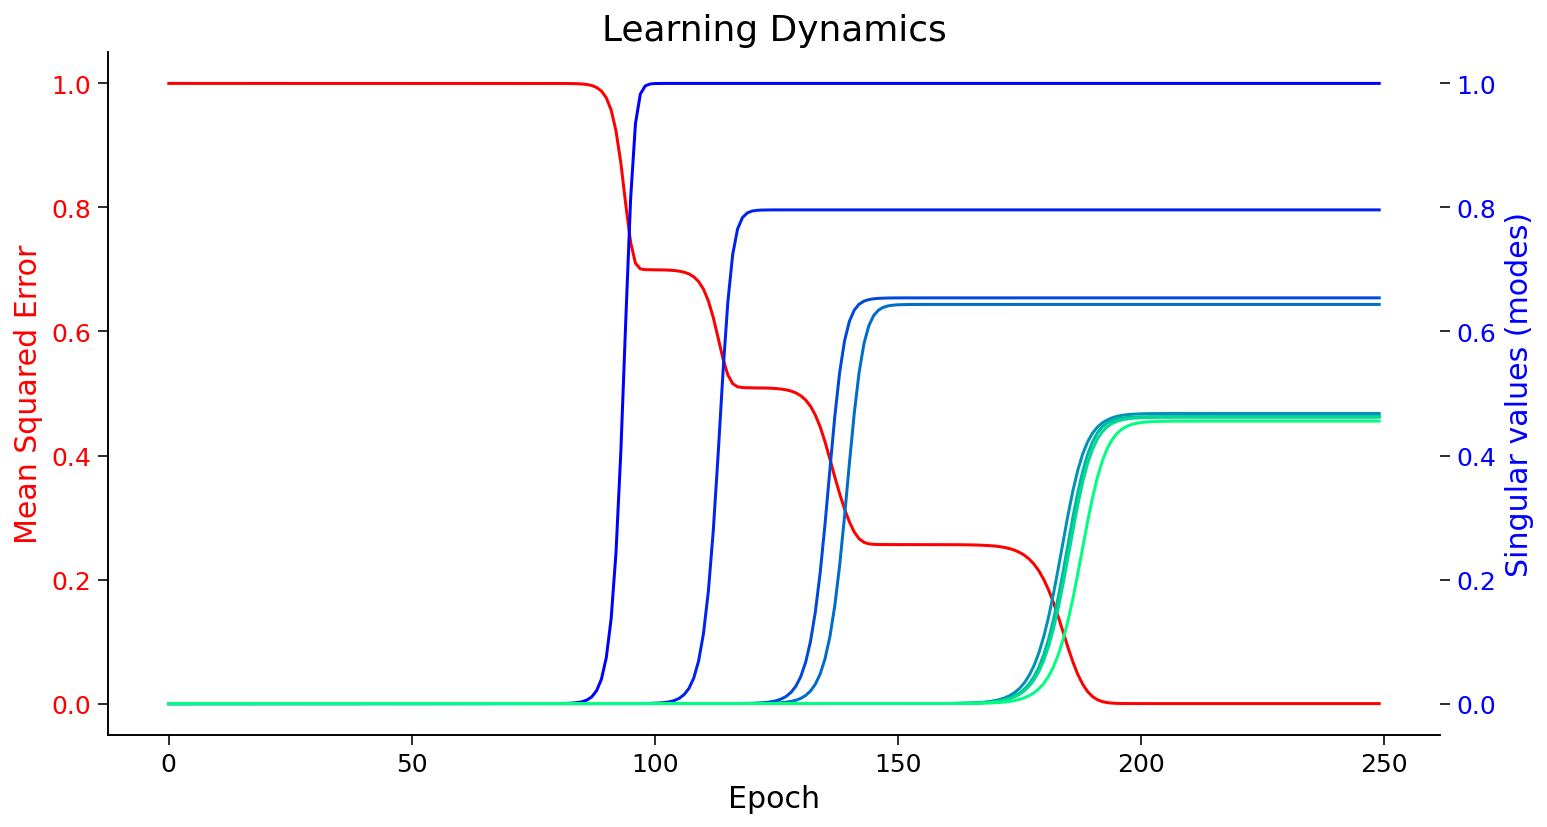

In [19]:
#@markdown Make sure you execute this cell to train the network and plot

dim_input = tree_labels.shape[1]
dim_output = tree_features.shape[1]
input_tensor = torch.tensor(tree_labels).float()
output_tensor = torch.tensor(tree_features).float()

deep_model = VariableDepthWidth(in_dim=dim_input,
                                    out_dim=dim_output,
                                    hid_dims=[30])

training_losses, singular_values, _, _ = train_svd_rsa_track(deep_model,
                        input_tensor,
                        output_tensor,
                        n_epochs=250,
                        lr=100.0)

plot_loss_sv_twin(training_losses, singular_values)

**Question**: Isn't this beautiful? For EigenValue decomposition, the anount of variance explained by eigenvectors are proportional to the corresponding eigenvalues. What about the SVD? We definitely see that the gradient descent guides the network to first learn the features that carry more information (have higher singular value)!

---
# Section 3: Representational Similarity Analysis (RSA)

Video available at https://youtu.be/19seHV97WkI


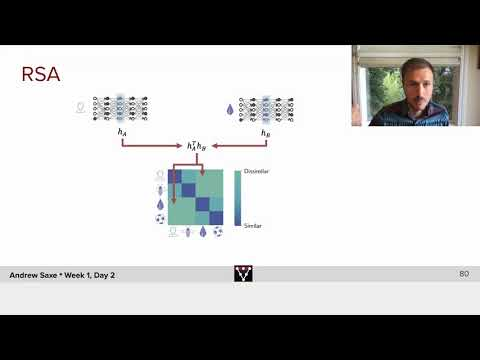

In [20]:
#@title Video 3.1: Representational Similarity Analysis (RSA)
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="19seHV97WkI", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


The previous section ended with an interesting remark! The network (through gradient descent), seems to prioritize learning features that explain most of the data, and gradually learn all the hidden representations. Given that we are training a hierarchically structured data, we may be able to see that progress as well.

To do so, we get help from Representational Similarity Analysis (RSA) approach to understand the internal representation of our network. The main idea is that the activity of hidden units (neurons) in the network must be similar when the network is presented with a similar input. The exercise will help more to get an intuition of this approach and the dynamics of representational learning.

## Exercise 3: RSA

We need to modify our training function once more. The task is to calculate similarity between the hidden layer activities (i.e. $~\mathbf{h_1} = \mathbf{W_1} \mathbf{x}~$) for all the inputs at every epoch. For similarity measure, we can use the good old dot (scalar) product, which is also called cosine similarity. For calculating the dot product between multiple vectors (which would be our case), you can simply use matrix multiplication. Therefore the Representational Similarity Matrix (SM) for multiple input activity could be calculated as follow:

$$ RSM = \mathbf{H_1}^{\top} \mathbf{H_1} $$

where $\mathbf{H_1} = \mathbf{W_1} \mathbf{X}$.

In [21]:
def train_svd_rsa_exercise(model, in_features, out_features, n_epochs, lr):
  """Training function
  
  Args:
    model (torch nn.Module): the neural network
    in_features (torch.Tensor): features (input) with shape `torch.Size([batch_size, input_dim])`
    out_features (torch.Tensor): targets (labels) with shape `torch.Size([batch_size, output_dim])`
    n_epochs (int): number of training epochs
    lr(float): learning rate

  Returns:
    np.ndarray: record (evolution) of losses
    np.ndarray: record (evolution) of singular values
    np.ndarray: record (evolution) of representational similarity matrices
  """
  
  assert in_features.shape[0] == out_features.shape[0]
  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  loss_record = []  # for recoding losses
  sv_record = []  # for recoding singular values
  rsm_record = []  # for recording representational similarity matrices

  for i in range(n_epochs):
    y_pred = model(in_features)  # forward pass
    loss = criterion(y_pred, out_features)  # calculating the loss
    optimizer.zero_grad()  # reset all the graph gradients to zero
    loss.backward()  # back propagation of the error
    optimizer.step()  # gradient step
    
    # calculating the W_tot by multiplying all layers' weights
    W_tot = model.layers[-1].weight.detach()  # starting from the last layer
    for i in range(2, len(model.layers)+1):
      W_tot = W_tot @ model.layers[-i].weight.detach()
    U, Σ, V = torch.svd(W_tot)  # performing the SVD!

    # calculating representational similarity matrix
    H1 = model.layers[0].weight.detach() @ in_features
    #################################################
    ## Use H1 to calculate the representational similarity matrix
    # Complete the function and remove or comment the line below
    raise NotImplementedError("Calculate the RSM")
    #################################################
    RSM = ...

    loss_record.append(loss.item())
    sv_record.append(Σ.numpy())
    rsm_record.append(RSM.numpy())

  return np.array(loss_record), np.array(sv_record), np.array(rsm_record)


In [22]:
# to_remove solution
def train_svd_rsa_exercise(model, in_features, out_features, n_epochs, lr):
  """Training function
  
  Args:
    model (torch nn.Module): the neural network
    in_features (torch.Tensor): features (input) with shape `torch.Size([batch_size, input_dim])`
    out_features (torch.Tensor): targets (labels) with shape `torch.Size([batch_size, output_dim])`
    n_epochs (int): number of training epochs
    lr(float): learning rate

  Returns:
    np.ndarray: record (evolution) of losses
    np.ndarray: record (evolution) of singular values
    np.ndarray: record (evolution) of representational similarity matrices
  """
  
  assert in_features.shape[0] == out_features.shape[0]
  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  loss_record = []  # for recoding losses
  sv_record = []  # for recoding singular values
  rsm_record = []  # for recording representational similarity matrices

  for i in range(n_epochs):
    y_pred = model(in_features)  # forward pass
    loss = criterion(y_pred, out_features)  # calculating the loss
    optimizer.zero_grad()  # reset all the graph gradients to zero
    loss.backward()  # back propagation of the error
    optimizer.step()  # gradient step
    
    # calculating the W_tot by multiplying all layers' weights
    W_tot = model.layers[-1].weight.detach()  # starting from the last layer
    for i in range(2, len(model.layers)+1):
      W_tot = W_tot @ model.layers[-i].weight.detach()
    U, Σ, V = torch.svd(W_tot)  # performing the SVD!

    # calculating representational similarity matrix
    H1 = model.layers[0].weight.detach() @ in_features
    RSM = H1.T @ H1

    loss_record.append(loss.item())
    sv_record.append(Σ.numpy())
    rsm_record.append(RSM.numpy())

  return np.array(loss_record), np.array(sv_record), np.array(rsm_record)


In [23]:
#@markdown Make sure you execute this cell to train the network

deep_model = VariableDepthWidth(in_dim=dim_input,
                                    out_dim=dim_output,
                                    hid_dims=[30])

training_losses, singular_values, rep_sim_mats, _ = train_svd_rsa_track(deep_model,
                        input_tensor,
                        output_tensor,
                        n_epochs=250,
                        lr=100.0)


Using the widget below, you can look at the representational similartiy matrix at any point of training.

In [24]:
#@markdown Make sure you execute this cell to enable the widget!

i_ep_slider = IntSlider(min=5, max=245, step=1, value=50,
                        continuous_update=False, description='Epoch',
                        layout=Layout(width='680px'))

widgets_ui = HBox([i_ep_slider])

widgets_out = interactive_output(plot_loss_sv_rsm,
                                         {'loss_array': fixed(training_losses),
                                          'sv_array': fixed(singular_values),
                                          'rsm_array': fixed(rep_sim_mats),
                                          'i_ep': i_ep_slider})

display(widgets_ui, widgets_out)

Output()

Video available at https://youtu.be/etsXyJJSru4


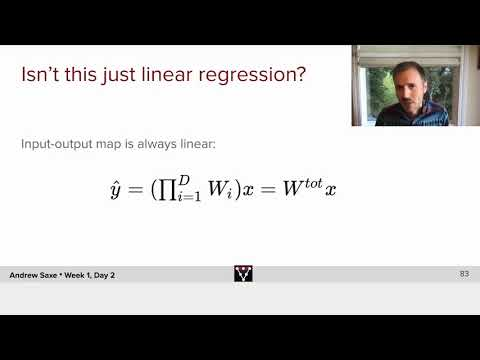

In [25]:
#@title Video 3.2: Linear Regression
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="etsXyJJSru4", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Demonstration: Linear Regression vs. DLNN

A linear neural network with NO hidden layer, is very similar to linear regression in its core. We also know that no matter how many hidden layers a linear network has, it can be compressed to a linear regression (no hidden layers).

In this demonstration, we use the hierarchically structured data to:

* analytically find the mapping between features and labels
* train a zero-depth LNN to find the mapping 
* compare them to the $W_{tot}$ from the already trained deep LNN

In [26]:
# calculating the W_tot for deep network (already trained model)
deep_weight_tot = deep_model.layers[-1].weight.detach().numpy()
for i in range(2, len(deep_model.layers)+1):
  deep_weight_tot = deep_weight_tot @ deep_model.layers[-i].weight.detach().numpy()


In [27]:
# analytically estimation of weights (map)
# our data is batch first dimension, so we need to transpose our data
analytical_weights = linear_regression(tree_labels.T, tree_features.T)


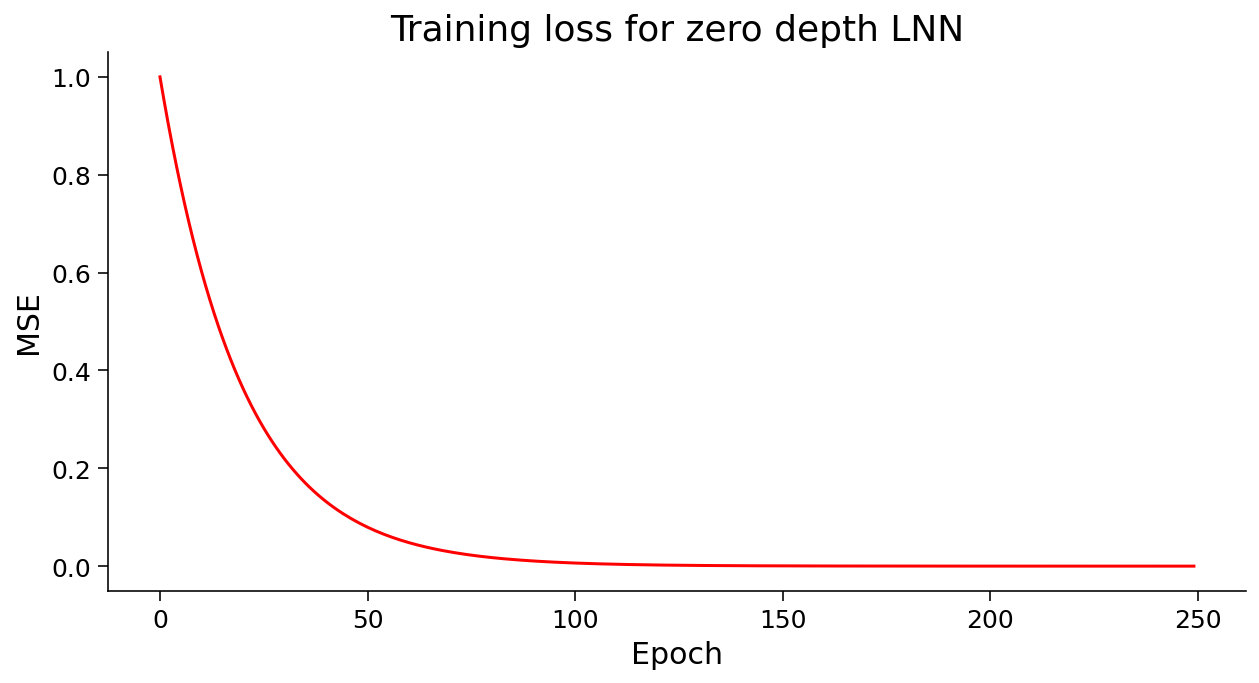

In [28]:
# create a model instance of VariableDepthWidth
zero_depth_model = VariableDepthWidth(in_dim=dim_input,
                                    out_dim=dim_output,
                                    hid_dims=[])
# train the zero_depth_model
training_losses = train(zero_depth_model,
                        input_tensor,
                        output_tensor,
                        n_epochs=250,
                        lr=1000.0)
# trained weights from zero_depth_model
zero_depth_model_weights = zero_depth_model.layers[0].weight.detach().numpy()

plot_loss(training_losses, "Training loss for zero depth LNN", c="r")


In [29]:
print("The final weights from all methods are approximately equal?! {}!\n".format(
  (np.allclose(analytical_weights, zero_depth_model_weights, atol=1e-02) and \
   np.allclose(analytical_weights, deep_weight_tot, atol=1e-02))))

The final weights from all methods are approximately equal?! True!



As you may have guessed, they all arrive at the same results but through very different paths.

---
# Section 4: Illusory Correlations

Video available at https://youtu.be/t_-wmMjl9kk


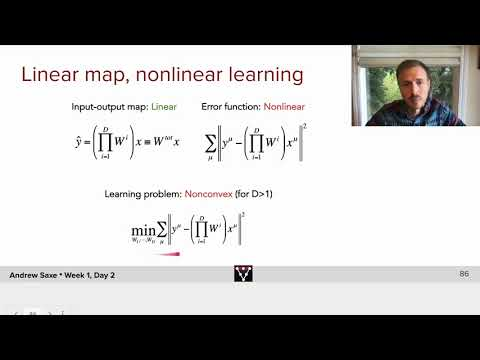

In [30]:
#@title Video 4.1: Illusory Correlations
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="t_-wmMjl9kk", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


So far, everything looks great, all our trainings are successful (training loss converging to zero), and very fast. We even could interpret the dynamics of our deep linear networks and relate them to the data. Unfortunately, this rarely happens in practice. Real world problems often require very deep and nonlinear networks with many hyper-parameters. And oridinarily, these complex networks take hours, if not days, to train.

Let's recall the training loss curves. There was often a long plateau (where the weights are stuck at a saddle point), followed by a sudden drop. For very deep complex neural network, such plateaus can last for hours of training, and we often decide to stop the training becasue we believe it "as good as it gets"! This riases a challenge of whether the network has learned all the "intended" hidden representations. But more importantly, the network might find an illusionary correlation between features that has never seen.

To better understand this, let's do the next demonstration and exercise.

## Demonstration: Illusory Correlations

So far we worked with a dataset that has 4 animals: Canary, Robin, Goldfish, and Tuna. These animals all have bones. Therefore if we include the "has bone" feature, the network would learn it at the second level (i.e. second bump, second singular value convergence), which is OK.

What if the dataset has Shark instead of Goldfish. Sharks don't have bones (their skeletons is made of cartilaginous, which is much lighter than true bone and more flexible). Then we will have feature which is *True* (i.e. +1) for Tuna, Robin, and Canary, but *False* (i.e. 0) for all the plants and the shark! Let's see what the network does.

First, we add the new feature to the targets. We then start training our LNN and in every epoch, record the network prediction for "sharks having bones".

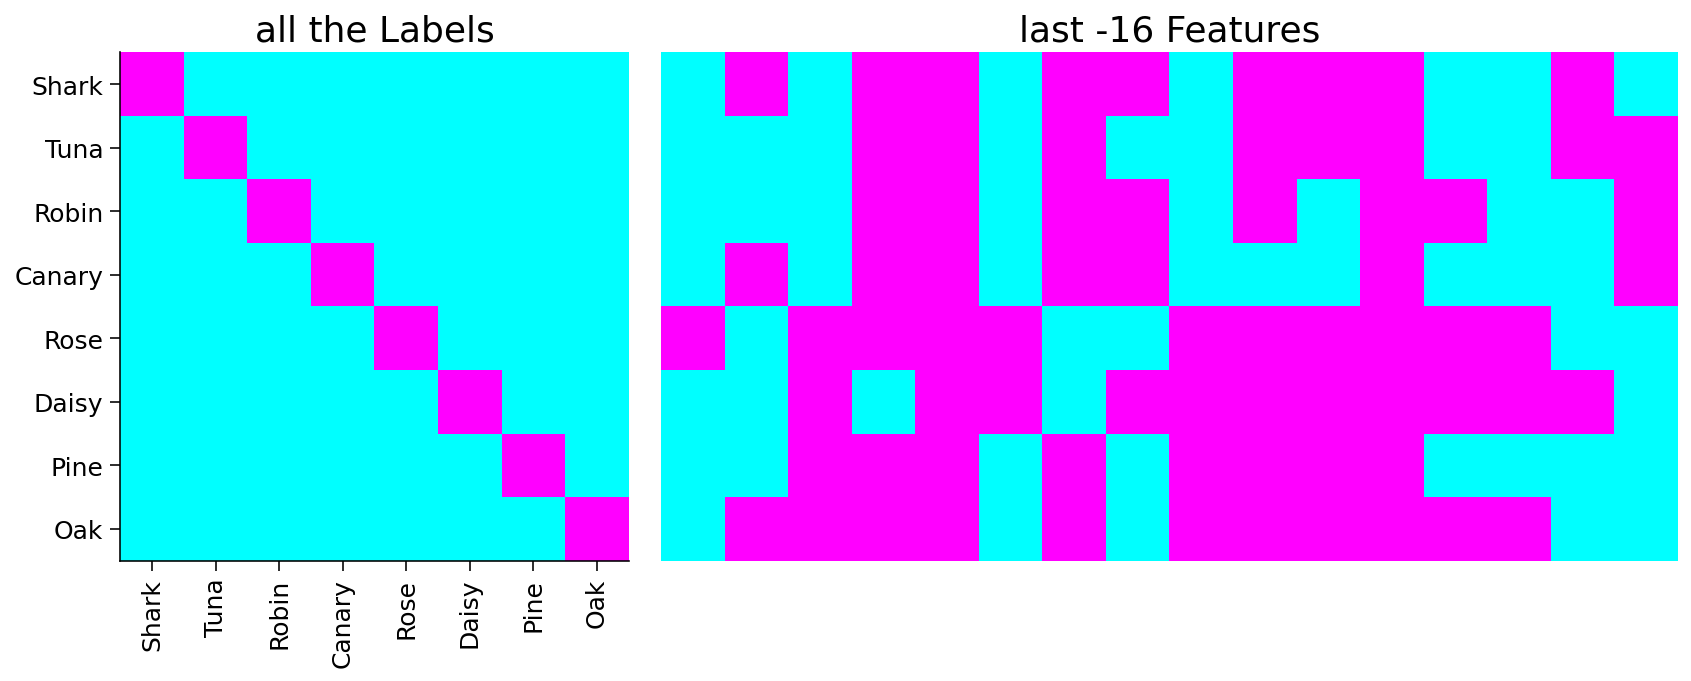

In [31]:
item_names = ['Shark', 'Tuna', 'Robin', 'Canary', 'Rose', 'Daisy', 'Pine', 'Oak']
has_bones = [0, 1, 1, 1, 0, 0, 0, 0]

tree_features = add_feature(tree_features, has_bones)
plot_tree_data(tree_labels, tree_features, item_names)

You can see the new feature shown in the last column of the plot above.

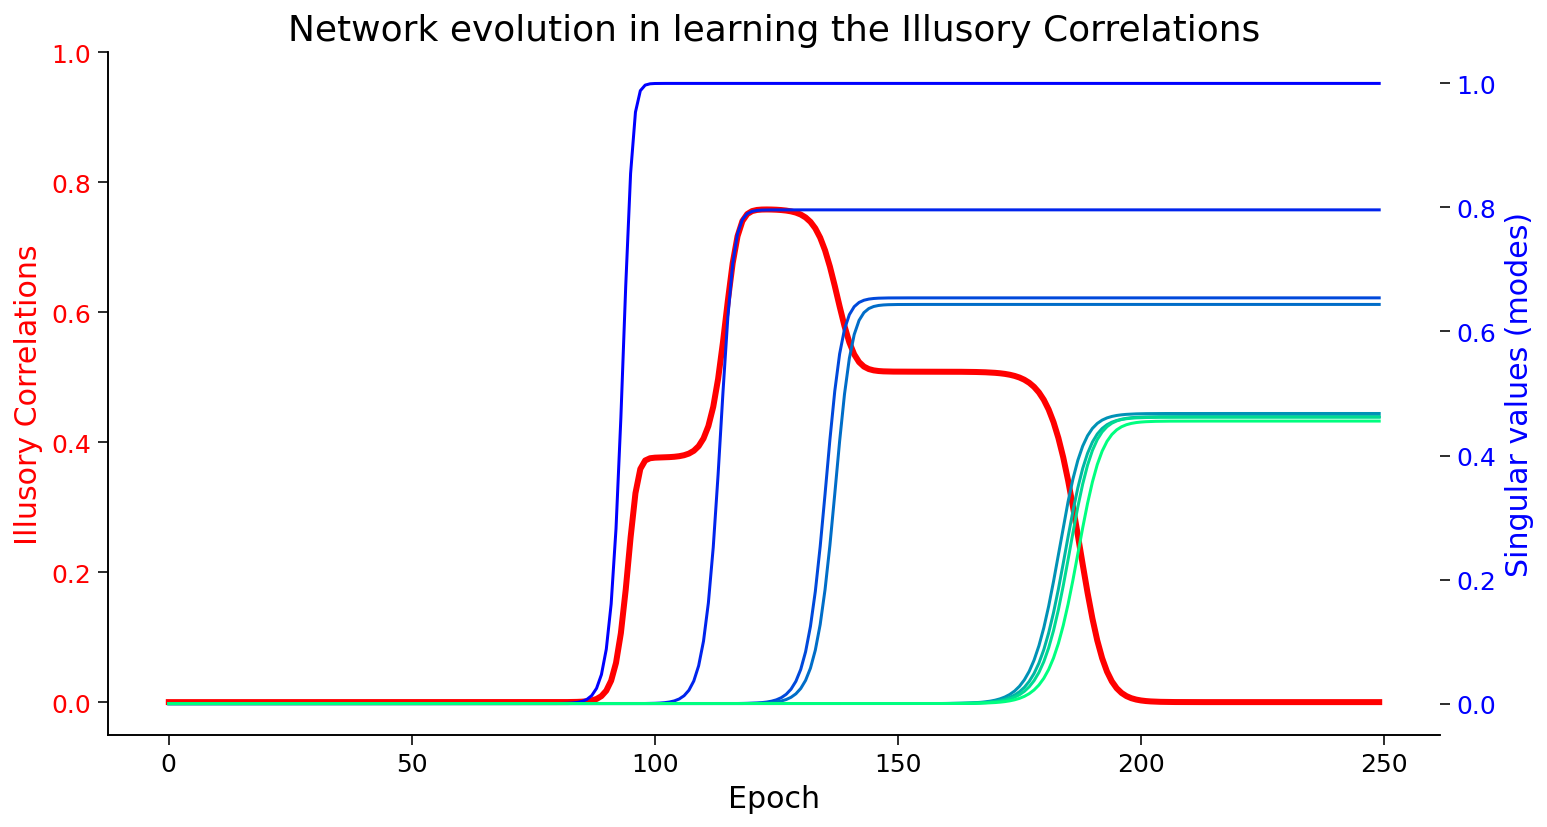

In [32]:
#@markdown Make sure you execute this cell to train the network
dim_input = tree_labels.shape[1]
dim_output = tree_features.shape[1]
input_tensor = torch.tensor(tree_labels).float()
output_tensor = torch.tensor(tree_features).float()

deep_model = VariableDepthWidth(in_dim=dim_input,
                                out_dim=dim_output,
                                hid_dims=[30])

_, singular_values, _, ill_predictions = train_svd_rsa_track(deep_model,
                                              input_tensor,
                                              output_tensor,
                                              n_epochs=250,
                                              lr=100.0,
                                              ill_i=0)

plot_ills_sv_twin(ill_predictions, singular_values)

It seems that the network starts by learning the "[alternative fact](https://en.wikipedia.org/wiki/Alternative_facts)" that sharks have bones, and in later epochs, as it learns deeper representations, it can see (learn) beyond the illusory correlation. This is important to remember that we never presented the network with any data saying that sharks have bones.

Video available at https://youtu.be/QMuTlq-atlc


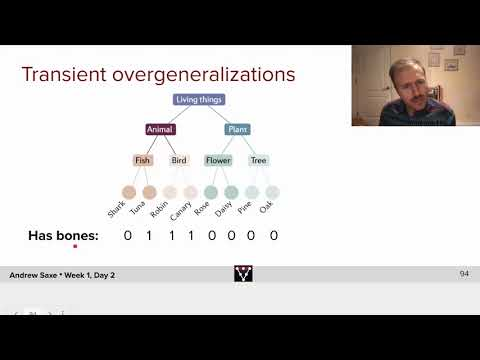

In [33]:
#@title Video 4.2: Illusory Correlations Explained
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="QMuTlq-atlc", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


## Exercise 4: Illusory Correlations

This exercise is just for you to explore the idea of illusory correlations. Think of medical, natural or possibly social illusory correlations which can test the learning power of deep linear neural nets.

**Notes**: Before you start, there are few things to important to know:

* the generated data is independent of tree labels, therefore the names are just for convenience.

* you can rename any node in the tree object(from the `SimpleTree` class) to help you keep track of your tree. This tree, also is not the one generating the samples and is purely for convenience.

Here is our example for **Non-human Living things don't speak**:


In [34]:
# this is just for plotting a tree and has no connection to data!
tree = SimpleTree()  # creates a tree
tree.rename("Canary", "Parrot")  # renames the Canary node to Parrot
tree.plot()  # plots the tree

Living things
╠══ Animal
║   ╠══ Bird
║   ║   ╠══ Parrot
║   ║   ╚══ Robin
║   ╚══ Fish
║       ╠══ Goldfish
║       ╚══ Tuna
╚══ Plant
    ╠══ Flower
    ║   ╠══ Daisy
    ║   ╚══ Rose
    ╚══ Tree
        ╠══ Oak
        ╚══ Pine



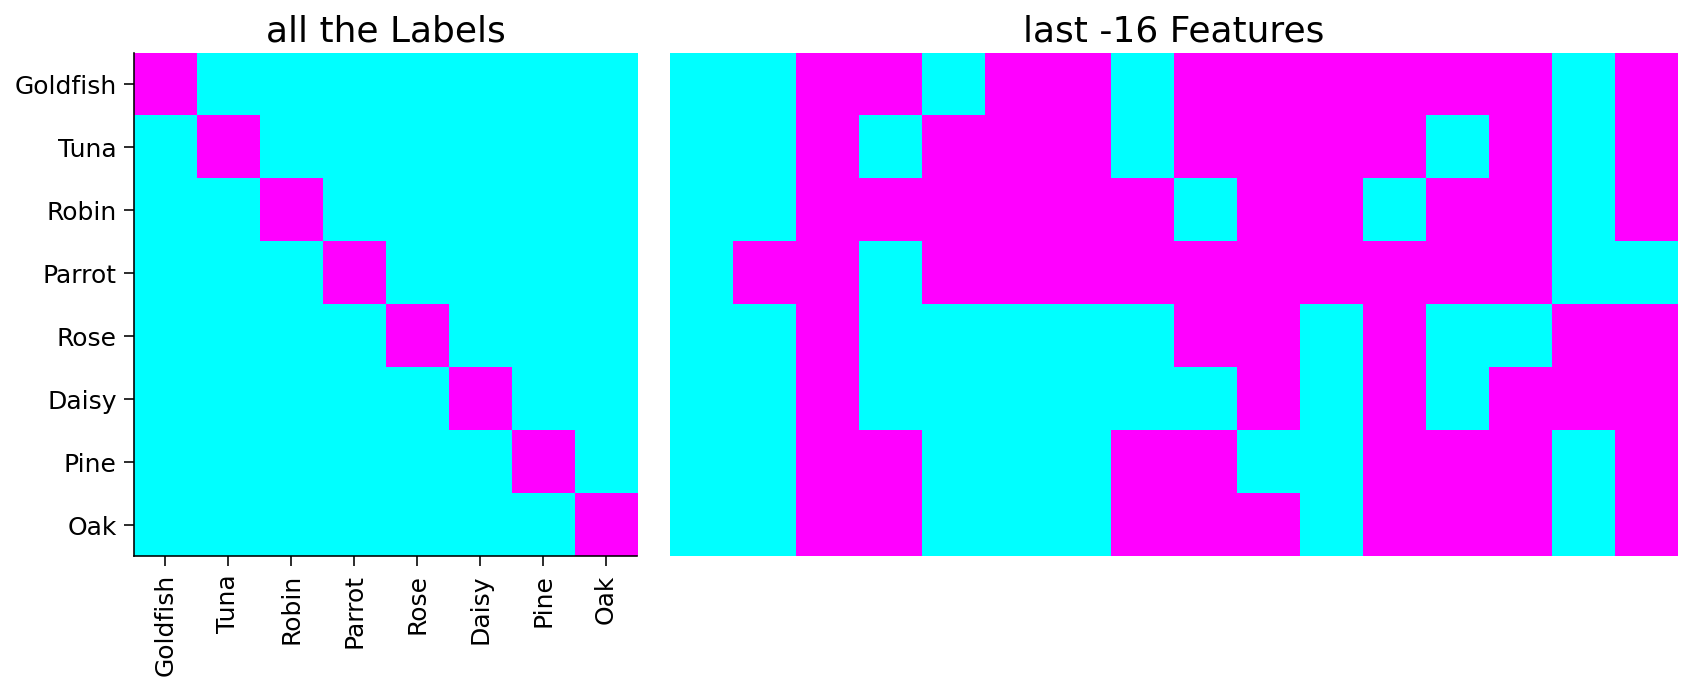

In [35]:
item_names = ['Goldfish', 'Tuna', 'Robin', 'Parrot', 'Rose', 'Daisy', 'Pine', 'Oak']
can_NOT_speak = [1, 1, 1, 0, 1, 1, 1, 1]  # creating the new feature 
ill_id = 3  # the index of your feature 

tree_labels, tree_features = generate_hsd()  # sampling new data from the tree
tree_features = add_feature(tree_features, can_NOT_speak) # adding the feature
plot_tree_data(tree_labels, tree_features, item_names)  # plot

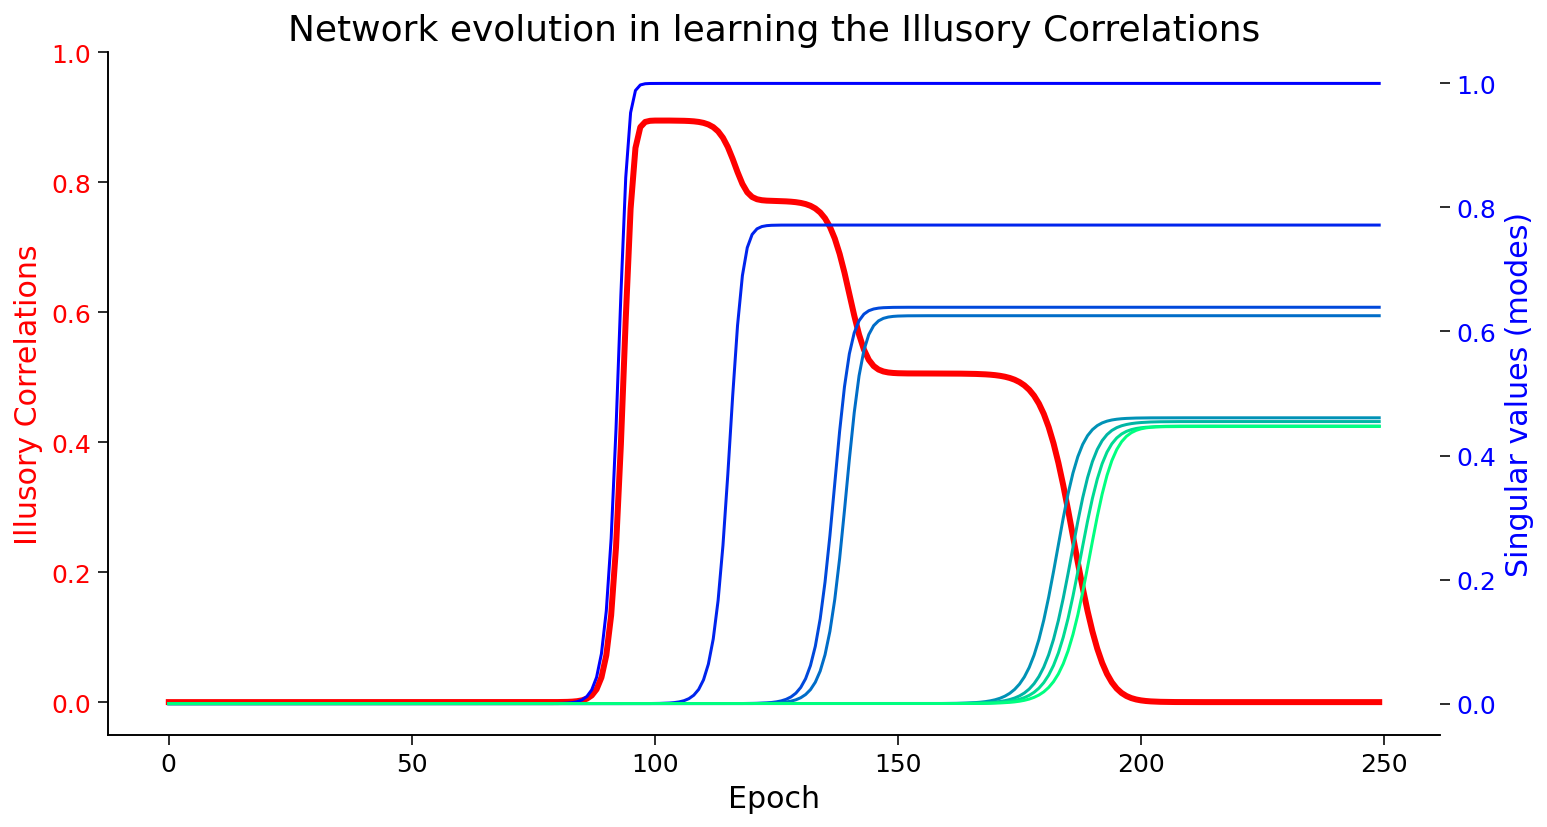

In [36]:
#@markdown Make sure you execute this cell to train the network and plot the output
dim_input = tree_labels.shape[1]
dim_output = tree_features.shape[1]
input_tensor = torch.tensor(tree_labels).float()
output_tensor = torch.tensor(tree_features).float()

deep_model = VariableDepthWidth(in_dim=dim_input,
                                out_dim=dim_output,
                                hid_dims=[30])

_, singular_values, _, ill_predictions = train_svd_rsa_track(deep_model,
                                              input_tensor,
                                              output_tensor,
                                              n_epochs=250,
                                              lr=100.0,
                                              ill_i=ill_id)

plot_ills_sv_twin(ill_predictions, singular_values)

---
# Wrap up

Video available at https://youtu.be/Y0JfyCtikhc


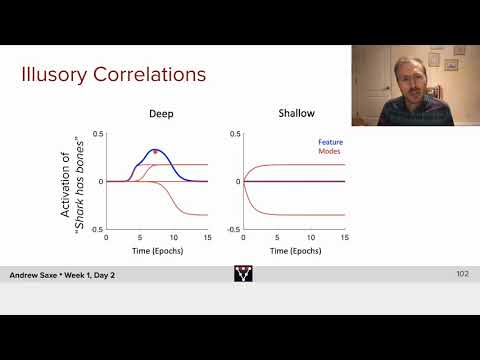

In [37]:
#@title Video 4.3: Outro
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Y0JfyCtikhc", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---
# Appendix

Generally, *regression* refers to a set of methods for modeling the mapping (relationship) between one (or more) independent variable(s) (i.e. features) and one (or more) dependent variable(s) (i.e. labels). For example, if we want to examine the relative impacts of calendar date, GPS coordinates, and time of the say (the independent variables) on air temperature (the dependent variable). On the other hand, regression can be used for predictive analysis. Thus the independent variables are also called predictors. When the model contains more than one predictor, then the method is called *multiple regression*, and if it contains more than one dependent variable called *multivariate regression*. Regression problems pop up whenever we want to predict a numerical (usually continuous) value.

The independent variables are collected in vector $\mathbf{x} \in \mathbb{R}^M$, where $M$ denotes the number of independent variables, while the dependent variables are collected in vector $\mathbf{y} \in \mathbb{R}^N$, where $N$ denotes the number of independent variables. And the mapping between them is represented by the weight matrix $\mathbf{W} \in \mathbb{R}^{N \times M}$ and a bias vector $\mathbf{b} \in \mathbb{R}^{N}$ (generalizing to affine mappings).

The multivariate regression model can be written as:

\begin{equation}
\mathbf{y} = \mathbf{W} ~ \mathbf{x} + \mathbf{b}
\end{equation}

or it can be written in matrix format as:

\begin{equation}
\begin{bmatrix} y_{1} \\ y_{2} \\ \vdots \\ y_{N} \\ \end{bmatrix} = \begin{bmatrix} w_{1,1} & w_{1,2} & \dots & w_{1,M} \\ w_{2,1} & w_{2,2} & \dots & w_{2,M} \\ \vdots & \ddots & \ddots & \vdots \\ w_{N,1} & w_{N,2} & \dots & w_{N,M} \end{bmatrix} \begin{bmatrix} x_{1} \\ x_{2} \\ \vdots \\ x_{M} \\ \end{bmatrix} + \begin{bmatrix} b_{1} \\ b_{2} \\ \vdots \\b_{N} \\ \end{bmatrix}
\end{equation}


__Vectorized regression__

Linear regression can be simply extended to multi-samples ($D$) input-output mapping, which we can collect in a matrix $\mathbf{X} \in \mathbb{R}^{M \times D}$, sometimes called the design matrix. The sample dimension also shows up in the output matrix $\mathbf{Y} \in \mathbb{R}^{N \times D}$. Thus, linear regression takes the following form:

\begin{equation}
\mathbf{Y} = \mathbf{W} ~ \mathbf{X} + \mathbf{b}
\end{equation}

where matrix $\mathbf{W} \in \mathbb{R}^{N \times M}$ and the vector $\mathbf{b} \in \mathbb{R}^{N}$ (broudcasted over sample dimension) are the desired parameters to find.